
Findings: 

The higher I make this the more accurate the classifier gets in terms of predicting non binding

Thus with more samples in zero binding we get less samples in training on binding which makes the mse much worse (the model simply cannot find a way to predicting strong binding values)

no matter what combinations I try, wether it be the non binding threshold, the zero_pred_threshold, or the layers in a binding predictor. I cannot even mean the mse of our mean predictor.

leaves me with the conclusion that there are not enough samples with a strong binding value in the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, global_add_pool, global_max_pool
from torch_geometric.data import Data, Batch

from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem.rdchem import BondType
from rdkit.Chem.rdchem import BondStereo

import numpy as np
from scipy.stats import pearsonr
import rdkit.Chem as Chem
from rdkit.Chem import rdFingerprintGenerator
from scipy.spatial.distance import pdist, squareform
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.cluster import KMeans

from typing import Tuple, List, Dict, Optional, Union

from lightning.pytorch.utilities.combined_loader import CombinedLoader

from tqdm import tqdm

In [2]:
def cluster_glycans(glycans, radius, fp_size, n_clusters):

    def get_morgan_count_fingerprint(smiles, radius, fp_size):
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return {f"mf_{i}": 0 for i in range(fp_size)} 


        #The useChirality parameter in Morgan fingerprints determines whether chirality is considered when encoding a molecule.
        #includeChirality=True = Differentiates between enantiomers (model will treat mirror-image molecules as different)
        #includeChirality=False = Ignores chirality (model will treat mirror-image molecules as the same)
        kid_named_morgan_finger = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fp_size, includeChirality=True)

        cfp = kid_named_morgan_finger.GetCountFingerprint(mol)  
        bit_counts = cfp.GetNonzeroElements()  

        # Convert to a full fp_size-length feature vector
        fingerprint_vector = {f"mf_{i}": bit_counts.get(i, 0) for i in range(fp_size)}
        return fingerprint_vector

    fingerprint_df = glycans['SMILES'].apply(lambda x: get_morgan_count_fingerprint(x, radius, fp_size)).apply(pd.Series)
    
    glycans = pd.concat([glycans, fingerprint_df], axis=1)
    
    # matrix version of fingerprint features. Each row is a glycan, each column is a fingerprint component shape: (611, 2048)
    finger_counts_matrix = fingerprint_df.values
    # pdist calculates the euclidean distance between the combination of each glycan with every other glycan. Then squareform() turns this into a matrix representation where each row is a glycan and each column is the same list of glycans so we can have a comparison matrix. Shape: (611, 611)
    dist_matrix = squareform(pdist(finger_counts_matrix, metric="euclidean"))
    

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(dist_matrix)
    
    glycans['cluster_label'] = labels
    
    return glycans

def cluster_proteins(proteins, n_clusters):
    
    
    def compute_protein_features(seq):

        # Add reasoning for feature vectors
        
        # Protein Analysis is a Tool from Biopython
        analysis = ProteinAnalysis(seq)
        features = {}
        
        # The following are Basic Features
        features['length'] = len(seq)
        features['mw'] = analysis.molecular_weight()
        features['instability_index'] = analysis.instability_index()

        features['net_charge_pH7'] = analysis.charge_at_pH(7.0)

        aa_percent = analysis.get_amino_acids_percent()

        # Prompted ChatGPT to ask how to parse a
        # N, Q, S, T: Polar Amino Acids, often involved in hydrogen bonding with glycans
        # K, R: Basic Amino Acids, can form hydrogen bonds and electrostatic bonds
        # D, E: Acidic Amino Acids, can interact with positively charged groups of glycans
        for aa in ['N', 'Q', 'S', 'T', 'K', 'R', 'D', 'E']:
            features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)

    
    # F, Y, W are aromatic amino acids which bind with glycans
        for aa in ['F', 'Y', 'W']:
            features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)
            features['aromatic_binding_score'] = (
            aa_percent.get('F', 0.0) +
            aa_percent.get('Y', 0.0) +
            aa_percent.get('W', 0.0)
        )

        features['aromaticity'] = analysis.aromaticity()

        features['hydrophobicity'] = analysis.gravy()

        return features

    feature_dicts = proteins['Amino Acid Sequence'].apply(compute_protein_features)
    features_df = pd.DataFrame(list(feature_dicts))

    proteins = pd.concat([proteins, features_df], axis=1)
    
    # Select the feature columns (all columns from the feature extraction)
    feature_columns = features_df.columns.tolist()
    feature_data = proteins[feature_columns].values

    # apply k means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    proteins['cluster_label'] = kmeans.fit_predict(feature_data)
    
    return proteins

def stratified_train_test_split(fractions_df, glycans_df, proteins_df, test_size, random_state, mode='AND'):
    """
    Create a stratified train-test split where:
    1. Test set has unique GlycanIDs and ProteinGroups not seen in training
    2. Distribution of cluster_labels for both glycans and proteins is maintained
    
    Parameters:
    -----------
    fractions_df : pandas.DataFrame
        DataFrame containing ['ObjId', 'ProteinGroup', 'Concentration', 'GlycanID', 'f']
    glycans_df : pandas.DataFrame
        DataFrame containing ['Name', 'cluster_label'] where Name maps to GlycanID
    proteins_df : pandas.DataFrame
        DataFrame containing ['ProteinGroup', 'cluster_label']
    test_size : float, default=0.1
        Proportion of data to include in the test set
    random_state : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    train_indices : numpy.ndarray
        Indices of fractions_df that belong to the training set
    test_indices : numpy.ndarray
        Indices of fractions_df that belong to the test set
    """
    # Set random seed
    np.random.seed(random_state)
    
    # Merge cluster labels from glycans and proteins into fractions
    fractions_with_clusters = fractions_df.copy()
    
    # Map glycan cluster labels
    glycan_cluster_map = dict(zip(glycans_df['Name'], glycans_df['cluster_label']))
    fractions_with_clusters['glycan_cluster'] = fractions_with_clusters['GlycanID'].map(glycan_cluster_map)
    
    # Map protein cluster labels
    protein_cluster_map = dict(zip(proteins_df['ProteinGroup'], proteins_df['cluster_label']))
    fractions_with_clusters['protein_cluster'] = fractions_with_clusters['ProteinGroup'].map(protein_cluster_map)
    
    # Get unique glycans and proteins with their cluster labels
    unique_glycans = glycans_df[['Name', 'cluster_label']].drop_duplicates()
    unique_proteins = proteins_df[['ProteinGroup', 'cluster_label']].drop_duplicates()
    
    # Calculate target counts for each cluster in test set
    glycan_cluster_counts = unique_glycans['cluster_label'].value_counts().to_dict()
    protein_cluster_counts = unique_proteins['cluster_label'].value_counts().to_dict()
    
    glycan_test_counts = {cluster: max(1, int(np.ceil(count * test_size))) 
                         for cluster, count in glycan_cluster_counts.items()}
    protein_test_counts = {cluster: max(1, int(np.ceil(count * test_size))) 
                          for cluster, count in protein_cluster_counts.items()}
    
    # Select glycans and proteins for test set while respecting cluster distributions
    test_glycans = []
    for cluster, target_count in glycan_test_counts.items():
        cluster_glycans = unique_glycans[unique_glycans['cluster_label'] == cluster]['Name'].tolist()
        selected = np.random.choice(cluster_glycans, size=min(target_count, len(cluster_glycans)), replace=False)
        test_glycans.extend(selected)
    
    test_proteins = []
    for cluster, target_count in protein_test_counts.items():
        cluster_proteins = unique_proteins[unique_proteins['cluster_label'] == cluster]['ProteinGroup'].tolist()
        selected = np.random.choice(cluster_proteins, size=min(target_count, len(cluster_proteins)), replace=False)
        test_proteins.extend(selected)
        
        
    if mode == 'AND':
        
        is_test = ((fractions_df['GlycanID'].isin(test_glycans)) & 
                (fractions_df['ProteinGroup'].isin(test_proteins)))

        is_train = ((~fractions_df['GlycanID'].isin(test_glycans)) & 
                        (~fractions_df['ProteinGroup'].isin(test_proteins)))
                
        test_indices = fractions_df[is_test].index

        train_indices = fractions_df[is_train].index
        
        print(f'-------------Test size (% of glycans and proteins as combinations in test set): {test_size*100}% -------------')

        print(f'train size: {len(train_indices)}, test size: {len(test_indices)}, total: {len(fractions_df)}')
                
        print(f'train size: {round((len(train_indices)/len(fractions_df))*100, 2)}%, test size: {round((len(test_indices)/len(fractions_df))*100, 2)}%')
        
        print(f'test size % in terms of test/(training+test) size: {round((len(test_indices)/(len(train_indices)+len(test_indices)))*100, 2)}%')
        
        print(f'Total % of dataset used: {round(((len(train_indices)+len(test_indices))/len(fractions_df))*100, 2)}%\n')
    
    else:
        print('OR operation selected')
        # Create train and test masks
        is_test = ((fractions_with_clusters['GlycanID'].isin(test_glycans)) | 
                (fractions_with_clusters['ProteinGroup'].isin(test_proteins)))
        
        test_indices = fractions_with_clusters[is_test].index
        train_indices = fractions_with_clusters[~is_test].index
    
    
    return train_indices, test_indices

def batch_encode(encoder, data_list, device, batch_size):
    """Process data in batches to avoid CUDA memory overflow"""
    all_encodings = []
    total_items = len(data_list)
    
    for i in range(0, total_items, batch_size):
        # Get current batch
        batch = data_list[i:min(i+batch_size, total_items)]
        
        # Encode batch
        batch_encodings = encoder.encode_batch(batch, device)
        all_encodings.append(batch_encodings)
        
        # Print progress
        print(f'Progress: {min(i+batch_size, total_items)}/{total_items}')
        
        # Optional: clear CUDA cache to prevent memory fragmentation
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    # Concatenate all batches
    return torch.cat(all_encodings, dim=0)

def prepare_train_val_datasets(
    fractions_df: pd.DataFrame,
    glycans_df: pd.DataFrame,
    proteins_df: pd.DataFrame,
    glycan_encoder,
    protein_encoder,
    glycan_type: str,
    random_state: int,
    split_mode: str,
    use_kfolds: bool,
    k_folds: float,
    val_split: float,
    device: torch.device
) -> Tuple[Dataset, Dataset]:
    """
    Prepare train and validation datasets
    
    Args:
        df: Full dataset DataFrame
        val_split: Fraction of data to use for validation
        glycan_encoder: Encoder for glycans
        protein_encoder: Encoder for proteins
    
    Returns:
        Tuple of train and validation datasets
    """
    
    # for each glycan create a glycan_encoding feature where we use glycan_encoder to encode the SMILES
    # for each protein create a protein_encoding feature where we use protein_encoder to encode the aminoacids
    #glycan_encodings = glycan_encoder.encode_batch(glycans_df[glycan_type].tolist(), device)
    #protein_encodings = protein_encoder.encode_batch(proteins_df['Amino Acid Sequence'].tolist(), device)

    # only do batch to not overload RAM of GPU
    if device.type == 'cuda':
        batch_size = 100  # Adjust based on your GPU memory

        # Encode glycans in batches
        glycan_encodings = batch_encode(
            glycan_encoder, 
            glycans_df[glycan_type].tolist(), 
            device, 
            batch_size=batch_size
        )

        # Encode proteins in batches
        protein_encodings = batch_encode(
            protein_encoder, 
            proteins_df['Amino Acid Sequence'].tolist(), 
            device, 
            batch_size=batch_size
        )
    else:
        glycan_encodings = glycan_encoder.encode_batch(glycans_df[glycan_type].tolist(), device)
        protein_encodings = protein_encoder.encode_batch(proteins_df['Amino Acid Sequence'].tolist(), device)
    
    
    # Might move to config but leave for now as our train and test are clusterd and stratified using these parameters
    radius = 3
    fp_size = 1024
    n_clusters = 3
    glycans_df = cluster_glycans(glycans_df, radius, fp_size, n_clusters)
    
    n_protein_clusters = 3
    proteins_df = cluster_proteins(proteins_df, n_protein_clusters)
    
    
    
    train_indicies, test_indicies = stratified_train_test_split(fractions_df, glycans_df, proteins_df, val_split, random_state, split_mode)
    # convert to kfold format so we can use the same code
    full_indicies = [(train_indicies, test_indicies)]
    
    return full_indicies, glycan_encodings, protein_encodings

In [3]:
class MPNNGlycanEncoder(nn.Module):
    def __init__(self, embedding_dim: int = 128, pos_emb_dim: int = 2,
                 hidden_state_size: int = 128, n_layers: int = 3):
        super().__init__()

        # Node features (118 + 1 + 1 + 1 + 4 = 125 dimensions)
        self.node_features = [
            'atomic_num',
            'mass',
            'row',
            'column',
            #'chirality',
        ]
        
        # Edge features (4 + 4 + 1 + 1 + 1 = 11 dimensions)
        self.edge_features = [
            'bond_type',
            'stero_configuration',
            #'is_in_ring',
            #'is_conjugated',
            #'is_aromatic',
        ]
        
        self._embedding_dim = embedding_dim
        self.pos_emb_dim = pos_emb_dim
        self.hidden_state_size = hidden_state_size
        self.n_layers = n_layers

        # Assume base node features have 125 dimensions.
        # (For example: one-hot atomic number (118) + mass (1) + row (1) + column (1) + chirality one-hot (4))
        self.base_node_feature_dim = 118 + 1 + 1 + 1 # + 4
        
        # After concatenating positional and structural embeddings, node feature dim becomes:
        self.node_feature_dim = self.base_node_feature_dim + self.pos_emb_dim + 2

        # Edge features dimension (example): 11.
        # (For example: bond type one-hot (4) + stereo configuration one-hot (4) + is_in_ring (1) + is_conjugated (1) + is_aromatic (1))
        self.edge_feature_dim = 4 + 4 # + 1 + 1 + 1

         # Initial projection to hidden state.
        self.initial_linear = nn.Linear(self.node_feature_dim, self.hidden_state_size)

        # Message passing function
        self.f_message = nn.Sequential(
            nn.Linear(self.hidden_state_size + self.edge_feature_dim, self.hidden_state_size),
            nn.GELU(),
            nn.Linear(self.hidden_state_size, self.hidden_state_size)
        )
        
        # Update function
        self.f_update = nn.Sequential(
            nn.Linear(2 * self.hidden_state_size, self.hidden_state_size),
            nn.GELU(),
            nn.Linear(self.hidden_state_size, self.hidden_state_size)
        )

        # Final readout projection.
        self.f_readout = nn.Linear(self.hidden_state_size, self._embedding_dim)
        
    def _get_random_walk_stats(self, adj: torch.Tensor, k_steps: int = 8) -> torch.Tensor:
        """
        Compute a k-step random walk bias matrix R = T^k (with T = D^-1 * A),
        and then derive per-node statistics (mean and std) for each node.
        Returns a tensor of shape (N, 2) where the two columns are mean and std.
        """
        deg = torch.sum(adj, dim=1, keepdim=True) + 1e-6
        T = adj / deg
        R = T.clone()
        for _ in range(k_steps - 1):
            R = R @ T
        # For each node, compute mean and standard deviation across the row.
        r_mean = R.mean(dim=1, keepdim=True)  # (N, 1)
        r_std = R.std(dim=1, keepdim=True)    # (N, 1)
        return torch.cat([r_mean, r_std], dim=1)  # (N, 2)


    def _get_positional_embeddings(self, adj: torch.Tensor, k: int) -> torch.Tensor:
        """
        Compute k-dimensional positional embeddings using the Laplacian eigenvectors.
        adj: (N, N) adjacency matrix.
        Returns: Tensor of shape (N, k)
        """
        # Compute degree vector and construct degree matrix D.
        deg = torch.sum(adj, dim=1)
        D = torch.diag(deg)
        # Compute Laplacian: L = D - A.
        L = D - adj
        # Compute eigen-decomposition (eigenvalues in ascending order).
        eigenvalues, eigenvectors = torch.linalg.eigh(L)
        # Skip the first eigenvector (trivial constant vector) if possible.
        if k < L.size(0):
            pos_emb = eigenvectors[:, 1:k+1]
        else:
            pos_emb = eigenvectors[:, :k]
        return pos_emb
    
    def _one_hot_atomic_number(self, atom):
        one_hot = [0] * 118
        atomic_num = atom.GetAtomicNum()
        one_hot[atomic_num - 1] = 1
        return one_hot
    
    def _one_hot_chirality(self, atom):
        chiral_tag = atom.GetChiralTag()
        possible_tags = [
            ChiralType.CHI_UNSPECIFIED, 
            ChiralType.CHI_TETRAHEDRAL_CW, 
            ChiralType.CHI_TETRAHEDRAL_CCW, 
            ChiralType.CHI_OTHER,
        ]
        one_hot = [1 if chiral_tag == tag else 0 for tag in possible_tags]
        return one_hot

    def _one_hot_bond_type(self, bond):
        bond_type = bond.GetBondType()
        possible_types = [
            BondType.SINGLE,
            BondType.DOUBLE,
            BondType.TRIPLE,
            BondType.AROMATIC,
        ]
        one_hot = [1 if bond_type == type else 0 for type in possible_types]
        return one_hot
    
    def _one_hot_stereo_configuration(self, bond):
        stereo = bond.GetStereo()
        possible_configurations = [
            BondStereo.STEREOANY,
            BondStereo.STEREOZ,
            BondStereo.STEREOE,
            BondStereo.STEREONONE,
        ]
        one_hot = [1 if stereo == config else 0 for config in possible_configurations]
        return one_hot
    
    def _get_atom_features(self, atom) -> List[float]:
        """Extract atom features according to the predefined list"""
        features = []

        # atomic number one hot encoding
        features += self._one_hot_atomic_number(atom)

        # atomic mass
        features.append(atom.GetMass())

        # row in periodic table / period
        features.append(element_row[atom.GetSymbol()])

        # column in periodic table / group
        features.append(element_col[atom.GetSymbol()])

        # chirality one hot encoding
        #features += self._one_hot_chirality(atom)

        return features
    
    def _get_bond_features(self, bond) -> List[float]:
        """Extract bond features according to the predefined list"""
        features = []

        # bond type one hot encoding
        features += self._one_hot_bond_type(bond)

        # stereo configuration one hot encoding
        features += self._one_hot_stereo_configuration(bond)

        # is in ring
        #features.append(bond.IsInRing())

        # is conjugated
        #features.append(bond.GetIsConjugated())

        # is aromatic
        #features.append(bond.GetIsAromatic())

        return features
    
    def _mol_to_graph_data(self, mol) -> dict:
        """
        Convert an RDKit molecule to a graph data dictionary containing:
          - x: node feature matrix (N x node_feature_dim)
          - adj: adjacency matrix (N x N)
          - edge_attr: edge feature tensor (N x N x edge_feature_dim)
          - batch: tensor indicating graph membership (for a single graph, all zeros)
        """
        # Build node features.
        node_features = [self._get_atom_features(atom) for atom in mol.GetAtoms()]
        x_raw = torch.tensor(node_features, dtype=torch.float)  # Shape: (N, node_feature_dim)
        N = x_raw.size(0)
        
        # Initialize dense adjacency and edge feature matrices.
        adj = torch.zeros((N, N), dtype=torch.float)
        edge_attr = torch.zeros((N, N, self.edge_feature_dim), dtype=torch.float)
        
        # Populate matrices for each bond.
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            adj[i, j] = 1.0
            adj[j, i] = 1.0
            bf = self._get_bond_features(bond)
            bf_tensor = torch.tensor(bf, dtype=torch.float)
            edge_attr[i, j] = bf_tensor
            edge_attr[j, i] = bf_tensor
        
        # Compute positional embeddings from the Laplacian.
        pos_emb = self._get_positional_embeddings(adj, self.pos_emb_dim)  # Shape: (N, pos_emb_dim)

        # Compute strucrtural embeddings (random walk statistics).
        rw_stats = self._get_random_walk_stats(adj)  # Shape: (N, 2)

        # Concatenate positional embeddings and structural embeddings to raw node features.
        x = torch.cat([x_raw, pos_emb, rw_stats], dim=1)  # Shape: (N, base_node_feature_dim + pos_emb_dim + 2)
        
        # Optionally, apply normalization (here we pass features through).
        x_norm = self._normalize_node_features(x)
        edge_attr_norm = self._normalize_edge_features(edge_attr)
        
        # For a single graph, assign all nodes to batch 0.
        batch = torch.zeros(N, dtype=torch.long)
        
        data = {
            'x': x,
            'adj': adj,
            'edge_attr': edge_attr,
            'x_norm': x_norm,
            'edge_attr_norm': edge_attr_norm,
            'batch': batch
        }
        return data 
    
    def _normalize_node_features(self, x):
        """Placeholder for node feature normalization."""
        return x

    def _normalize_edge_features(self, edge_attr):
        """Placeholder for edge feature normalization."""
        return edge_attr
    
    def encode_smiles(self, smiles: str, device: torch.device) -> torch.Tensor:
        """Convert a SMILES string to a graph embedding"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Could not parse SMILES: {smiles}")
        
        # Optionally add hydrogen atoms
        mol = Chem.AddHs(mol)
        
        # Convert to a graph data object
        data = self._mol_to_graph_data(mol)
        
        # Create a batch with just this single molecule
        data['batch'] = torch.zeros(data['x'].size(0), dtype=torch.long)

        # Move all tensor entries to device.
        for key in data:
            if isinstance(data[key], torch.Tensor):
                data[key] = data[key].to(device)
        with torch.no_grad():
            embedding = self.forward(data)
        return embedding
    
    def encode_iupac(self, iupacs: str, device: torch.device) -> torch.Tensor:
        pass
    
    def encode_batch(self, batch_data: List[str], device: torch.device) -> torch.Tensor:
        """Convert a batch of SMILES strings to graph embeddings"""
        # Process each molecule individually
        batch_embeddings = []
        for smiles in batch_data:
            embedding = self.encode_smiles(smiles, device)
            batch_embeddings.append(embedding)
        
        # Stack all embeddings
        batch = torch.cat(batch_embeddings, dim=0)
        
        return batch

    def preprocess_dataset(self, smiles_list: List[str]):
        """Precompute normalization parameters for the dataset"""
        # Convert all molecules to graphs and collect statistics
        all_node_features = []
        all_edge_features = []
        
        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
                
            # Add hydrogens
            #mol = Chem.AddHs(mol)
            
            # Collect node features
            for atom in mol.GetAtoms():
                features = self._get_atom_features(atom)
                all_node_features.append(features)
            
            # Collect edge features
            for bond in mol.GetBonds():
                features = self._get_bond_features(bond)
                all_edge_features.append(features)
        
        # Convert to tensors
        all_node_features = torch.tensor(all_node_features, dtype=torch.float)
        all_edge_features = torch.tensor(all_edge_features, dtype=torch.float)
        
        # Compute normalization parameters
        for i, feature_name in enumerate(self.node_features):
            feature_values = all_node_features[:, i]
            self.scalers[feature_name] = {
                'min': float(feature_values.min()),
                'max': float(feature_values.max()),
                'mean': float(feature_values.mean()),
                'std': float(feature_values.std())
            }
        
        for i, feature_name in enumerate(self.edge_features):
            feature_values = all_edge_features[:, i]
            self.scalers[feature_name] = {
                'min': float(feature_values.min()),
                'max': float(feature_values.max()),
                'mean': float(feature_values.mean()),
                'std': float(feature_values.std())
            }
        
        return self.scalers
    
    @property
    def embedding_dim(self) -> int:
        return self._embedding_dim
    
    def forward(self, data: dict) -> torch.Tensor:
        """
        Perform message passing to produce a graph-level embedding.
        data: Dictionary containing keys 'x_norm', 'adj', 'edge_attr_norm', 'batch'.
        """
        # Extract inputs.
        x = data['x_norm']        # (N, node_feature_dim) where node_feature_dim = base (125) + pos_emb_dim
        adj = data['adj']         # (N, N)
        edge_attr = data['edge_attr_norm']  # (N, N, edge_feature_dim)
        N = x.size(0)

        # Initial projection to hidden state.
        h = F.relu(self.initial_linear(x))  # (N, hidden_state_size)

        # Message passing iterations.
        for t in range(self.n_layers):
            h_neighbors = h.unsqueeze(0).expand(N, N, self.hidden_state_size)  # (N, N, hidden_state_size)
            msg_input = torch.cat([h_neighbors, edge_attr], dim=2)  # (N, N, hidden_state_size + edge_feature_dim)
            msg_input_flat = msg_input.view(-1, self.hidden_state_size + self.edge_feature_dim)
            messages_flat = self.f_message(msg_input_flat)  # (N*N, hidden_state_size)
            messages = messages_flat.view(N, N, self.hidden_state_size)  # (N, N, hidden_state_size)
            messages = messages * adj.unsqueeze(2)  # mask non-existent edges
            m = messages.sum(dim=1)  # aggregate messages by sum: (N, hidden_state_size)
            h = F.relu(self.f_update(torch.cat([h, m], dim=1)))  # update node states: (N, hidden_state_size)

        # Global mean pooling.
        graph_repr = h.sum(dim=0, keepdim=True)  # (1, hidden_state_size)
        out = self.f_readout(graph_repr)  # (1, embedding_dim)
        return out
    
# Hashmap for periodic table row (period) (used RdKit pt.GetRow())
element_row = {
    'H': 1,
    'He': 1,
    'Li': 2,
    'Be': 2,
    'B': 2,
    'C': 2,
    'N': 2,
    'O': 2,
    'F': 2,
    'Ne': 2,
    'Na': 3,
    'Mg': 3,
    'Al': 3,
    'Si': 3,
    'P': 3,
    'S': 3,
    'Cl': 3,
    'Ar': 3,
    'K': 4,
    'Ca': 4,
    'Sc': 4,
    'Ti': 4,
    'V': 4,
    'Cr': 4,
    'Mn': 4,
    'Fe': 4,
    'Co': 4,
    'Ni': 4,
    'Cu': 4,
    'Zn': 4,
    'Ga': 4,
    'Ge': 4,
    'As': 4,
    'Se': 4,
    'Br': 4,
    'Kr': 4,
    'Rb': 5,
    'Sr': 5,
    'Y': 5,
    'Zr': 5,
    'Nb': 5,
    'Mo': 5,
    'Tc': 5,
    'Ru': 5,
    'Rh': 5,
    'Pd': 5,
    'Ag': 5,
    'Cd': 5,
    'In': 5,
    'Sn': 5,
    'Sb': 5,
    'Te': 5,
    'I': 5,
    'Xe': 5,
    'Cs': 6,
    'Ba': 6,
    'La': 6,
    'Ce': 6,
    'Pr': 6,
    'Nd': 6,
    'Pm': 6,
    'Sm': 6,
    'Eu': 6,
    'Gd': 6,
    'Tb': 6,
    'Dy': 6,
    'Ho': 6,
    'Er': 6,
    'Tm': 6,
    'Yb': 6,
    'Lu': 6,
    'Hf': 6,
    'Ta': 6,
    'W': 6,
    'Re': 6,
    'Os': 6,
    'Ir': 6,
    'Pt': 6,
    'Au': 6,
    'Hg': 6,
    'Tl': 6,
    'Pb': 6,
    'Bi': 6,
    'Po': 6,
    'At': 6,
    'Rn': 6,
    'Fr': 7,
    'Ra': 7,
    'Ac': 7,
    'Th': 7,
    'Pa': 7,
    'U': 7,
    'Np': 7,
    'Pu': 7,
    'Am': 7,
    'Cm': 7,
    'Bk': 7,
    'Cf': 7,
    'Es': 7,
    'Fm': 7,
    'Md': 7,
    'No': 7,
    'Lr': 7,
    'Rf': 7,
    'Db': 7,
    'Sg': 7,
    'Bh': 7,
    'Hs': 7,
    'Mt': 7,
    'Ds': 7,
    'Rg': 7,
    'Cn': 7,
    'Nh': 7,
    'Fl': 7,
    'Mc': 7,
    'Lv': 7,
    'Ts': 7,
    'Og': 7,
}

# Hashmap for periodic table column (group) (manually entered)
element_col = {
    'H': 1,
    'He': 18,
    'Li': 1,
    'Be': 2,
    'B': 13,
    'C': 14,
    'N': 15,
    'O': 16,
    'F': 17,
    'Ne': 18,
    'Na': 1,
    'Mg': 2,
    'Al': 13,
    'Si': 14,
    'P': 15,
    'S': 16,
    'Cl': 17,
    'Ar': 18,
    'K': 1,
    'Ca': 2,
    'Sc': 3,
    'Ti': 4,
    'V': 5,
    'Cr': 6,
    'Mn': 7,
    'Fe': 8,
    'Co': 9,
    'Ni': 10,
    'Cu': 11,
    'Zn': 12,
    'Ga': 13,
    'Ge': 14,
    'As': 15,
    'Se': 16,
    'Br': 17,
    'Kr': 18,
    'Rb': 1,
    'Sr': 2,
    'Y': 3,
    'Zr': 4,
    'Nb': 5,
    'Mo': 6,
    'Tc': 7,
    'Ru': 8,
    'Rh': 9,
    'Pd': 10,
    'Ag': 11,
    'Cd': 12,
    'In': 13,
    'Sn': 14,
    'Sb': 15,
    'Te': 16,
    'I': 17,
    'Xe': 18,
    'Cs': 1,
    'Ba': 2,
    'La': 0,
    'Ce': 0,
    'Pr': 0,
    'Nd': 0,
    'Pm': 0,
    'Sm': 0,
    'Eu': 0,
    'Gd': 0,
    'Tb': 0,
    'Dy': 0,
    'Ho': 0,
    'Er': 0,
    'Tm': 0,
    'Yb': 0,
    'Lu': 3,
    'Hf': 4,
    'Ta': 5,
    'W': 6,
    'Re': 7,
    'Os': 8,
    'Ir': 9,
    'Pt': 10,
    'Au': 11,
    'Hg': 12,
    'Tl': 13,
    'Pb': 14,
    'Bi': 15,
    'Po': 16,
    'At': 17,
    'Rn': 18,
    'Fr': 1,
    'Ra': 2,
    'Ac': 0,
    'Th': 0,
    'Pa': 0,
    'U': 0,
    'Np': 0,
    'Pu': 0,
    'Am': 0,
    'Cm': 0,
    'Bk': 0,
    'Cf': 0,
    'Es': 0,
    'Fm': 0,
    'Md': 0,
    'No': 0,
    'Lr': 3,
    'Rf': 4,
    'Db': 5,
    'Sg': 6,
    'Bh': 7,
    'Hs': 8,
    'Mt': 9,
    'Ds': 10,
    'Rg': 11,
    'Cn': 12,
    'Nh': 13,
    'Fl': 14,
    'Mc': 15,
    'Lv': 16,
    'Ts': 17,
    'Og': 18,
}

In [4]:
class AdvancedGNNProteinEncoder(nn.Module):
    """
    Advanced Graph Neural Network-based Protein Encoder that incorporates:
    - Rich amino acid feature representation
    - Flexible graph structures (sequential, predicted contacts)
    - Attention-based message passing
    - Multiple readout functions
    """
    def __init__(self, 
                 embedding_dim: int = 256, 
                 hidden_channels: int = 128,
                 num_layers: int = 3,
                 dropout: float = 0.2,
                 use_attention: bool = True,
                 readout_mode: str = 'mean'):
        """
        Initialize the advanced GNN protein encoder.
        
        Args:
            embedding_dim: Final embedding dimension
            hidden_channels: Size of hidden layers in GNN
            num_layers: Number of GNN layers
            dropout: Dropout probability
            use_attention: Whether to use attention-based message passing
            readout_mode: Method for graph-level pooling ('mean', 'sum', 'max', 'mean+max')
        """
        super().__init__()
        self._embedding_dim = embedding_dim
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        self.use_attention = use_attention
        self.readout_mode = readout_mode
        
        # Feature dimensions
        self.aa_embedding_dim = 20  # One-hot encoding of amino acids
        self.physicochemical_dim = 12  # Various amino acid properties
        self.position_embedding_dim = 16  # Positional encoding
        
        # Total node feature dimension
        node_feature_dim = self.aa_embedding_dim + self.physicochemical_dim + self.position_embedding_dim
        
        # Amino acid mappings
        self.aa_to_idx = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
        self.default_idx = len(self.aa_to_idx)  # For unknown amino acids
        
        # Feature initialization layers
        self.position_embedding = nn.Embedding(1000, self.position_embedding_dim)  # Max sequence length of 1000
        
        # Physicochemical property mappings (pre-computed)
        self.aa_properties = self._initialize_aa_properties()
        
        # GNN layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # First layer takes the combined node features
        if use_attention:
            self.convs.append(GATConv(node_feature_dim, hidden_channels, heads=4, concat=False))
        else:
            self.convs.append(GCNConv(node_feature_dim, hidden_channels))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        
        # Additional layers
        for _ in range(num_layers - 1):
            if use_attention:
                self.convs.append(GATConv(hidden_channels, hidden_channels, heads=4, concat=False))
            else:
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))
        
        # Output projections depend on readout mode
        output_dim = hidden_channels if 'mean+max' not in readout_mode else hidden_channels * 2
        self.projection = nn.Sequential(
            nn.Linear(output_dim, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, embedding_dim)
        )
        
    def _initialize_aa_properties(self) -> Dict[str, torch.Tensor]:
        """Initialize physicochemical properties for each amino acid"""
        properties = {}
        
        # These values are based on common AA properties: 
        # hydrophobicity, charge, size, polarity, etc.
        
        # Define key properties for each amino acid (normalized)
        # Format: [hydrophobicity, charge, size, polarity, aromaticity, 
        #          h-bond donor, h-bond acceptor, pKa, pI, flexibility,
        #          reactivity, glycosylation_site]
        
        properties['A'] = torch.tensor([0.7, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.3, 0.1, 0.0])
        properties['C'] = torch.tensor([0.8, 0.0, 0.2, 0.1, 0.0, 0.5, 0.0, 0.9, 0.4, 0.2, 0.9, 0.0])
        properties['D'] = torch.tensor([0.3, -1.0, 0.3, 0.9, 0.0, 0.0, 1.0, 0.1, 0.3, 0.5, 0.4, 0.0])
        properties['E'] = torch.tensor([0.4, -1.0, 0.4, 0.8, 0.0, 0.0, 1.0, 0.2, 0.3, 0.5, 0.3, 0.0])
        properties['F'] = torch.tensor([0.9, 0.0, 0.6, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.2, 0.2, 0.0])
        properties['G'] = torch.tensor([0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.2, 0.0])
        properties['H'] = torch.tensor([0.5, 0.5, 0.5, 0.7, 0.5, 0.5, 0.5, 0.6, 0.7, 0.3, 0.6, 0.0])
        properties['I'] = torch.tensor([1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.1, 0.0])
        properties['K'] = torch.tensor([0.3, 1.0, 0.6, 0.8, 0.0, 0.5, 0.0, 1.0, 0.9, 0.5, 0.3, 0.0])
        properties['L'] = torch.tensor([0.9, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.2, 0.1, 0.0])
        properties['M'] = torch.tensor([0.7, 0.0, 0.5, 0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.3, 0.2, 0.0])
        properties['N'] = torch.tensor([0.3, 0.0, 0.3, 0.8, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.3, 1.0])
        properties['P'] = torch.tensor([0.5, 0.0, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.2, 0.0])
        properties['Q'] = torch.tensor([0.4, 0.0, 0.4, 0.7, 0.0, 0.5, 0.5, 0.0, 0.5, 0.4, 0.2, 0.0])
        properties['R'] = torch.tensor([0.2, 1.0, 0.7, 0.9, 0.0, 0.5, 0.0, 0.5, 1.0, 0.4, 0.3, 0.0])
        properties['S'] = torch.tensor([0.4, 0.0, 0.2, 0.6, 0.0, 0.5, 0.5, 0.0, 0.5, 0.6, 0.2, 0.5])
        properties['T'] = torch.tensor([0.5, 0.0, 0.3, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.4, 0.2, 0.5])
        properties['V'] = torch.tensor([0.8, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.2, 0.1, 0.0])
        properties['W'] = torch.tensor([0.6, 0.0, 0.8, 0.1, 1.0, 0.5, 0.0, 0.0, 0.5, 0.1, 0.2, 0.0])
        properties['Y'] = torch.tensor([0.7, 0.0, 0.7, 0.4, 0.8, 0.5, 0.5, 0.3, 0.5, 0.2, 0.3, 0.0])
        
        # Default for unknown amino acids (average values)
        properties['X'] = torch.mean(torch.stack([prop for prop in properties.values()]), dim=0)
        
        return properties
        
    def _one_hot_encode_aa(self, aa: str) -> torch.Tensor:
        """One-hot encode an amino acid"""
        idx = self.aa_to_idx.get(aa, self.default_idx)
        one_hot = torch.zeros(self.aa_embedding_dim)
        if idx < self.aa_embedding_dim:
            one_hot[idx] = 1.0
        return one_hot
    
    def _get_aa_properties(self, aa: str) -> torch.Tensor:
        """Get physicochemical properties for an amino acid"""
        return self.aa_properties.get(aa, self.aa_properties['X'])
    
    def _sequence_to_graph(self, 
                          sequence: str, 
                          contact_map: Optional[Union[torch.Tensor, List, np.ndarray, None]] = None,
                          distance_threshold: float = 8.0) -> Data:
        """
        Convert a protein sequence to a graph representation.
        
        Args:
            sequence: Amino acid sequence
            contact_map: Optional tensor of pairwise distances/contacts
            distance_threshold: Threshold for considering residues in contact
            
        Returns:
            PyTorch Geometric Data object
        """
        # Node features: combine one-hot encoding, properties, and position
        x = []
        for i, aa in enumerate(sequence):
            if aa not in self.aa_to_idx and aa != 'X':
                aa = 'X'  # Use default for unknown amino acids
                
            # Combine features
            one_hot = self._one_hot_encode_aa(aa)
            properties = self._get_aa_properties(aa)
            position = self.position_embedding(torch.tensor([min(i, 999)]))
            
            # Concatenate all features
            features = torch.cat([one_hot, properties, position.squeeze(0)])
            x.append(features)
            
        # Create node features tensor
        x = torch.stack(x)
        
        # Create edge index
        edge_index = []
        
        # Add sequential connections (each AA connected to neighbors within window)
        window_size = 3  # Connect each AA to this many neighbors in each direction
        for i in range(len(sequence)):
            # Connect to previous AAs within window
            for w in range(1, window_size + 1):
                if i - w >= 0:
                    edge_index.append([i-w, i])
                    edge_index.append([i, i-w])  # Bidirectional
            
            # Connect to next AAs within window
            for w in range(1, window_size + 1):
                if i + w < len(sequence):
                    edge_index.append([i, i+w])
                    edge_index.append([i+w, i])  # Bidirectional
        
        # Add contacts from contact map if provided
        if contact_map is not None:
            try:
                # Convert to tensor if not already
                if not isinstance(contact_map, torch.Tensor):
                    if isinstance(contact_map, np.ndarray):
                        contact_map = torch.tensor(contact_map)
                    elif isinstance(contact_map, list):
                        contact_map = torch.tensor(contact_map)
                
                # Only use contact map if it's now a tensor with the right shape
                if isinstance(contact_map, torch.Tensor) and contact_map.dim() == 2:
                    for i in range(len(sequence)):
                        for j in range(i + window_size + 1, min(len(sequence), contact_map.shape[0])):
                            # Check dimensions to avoid index errors
                            if i < contact_map.shape[0] and j < contact_map.shape[1]:
                                if contact_map[i, j] <= distance_threshold:
                                    edge_index.append([i, j])
                                    edge_index.append([j, i])  # Bidirectional
            except Exception as e:
                # If we encounter any error with the contact map, just ignore it
                print(f"Warning: Could not use contact map: {e}")
        
        # Create edge index tensor
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        else:
            # Handle case with no edges (very short sequence)
            edge_index = torch.zeros((2, 0), dtype=torch.long)
        
        # Create PyG Data object
        data = Data(x=x, edge_index=edge_index)
        return data
    
    def forward(self, data: Data) -> torch.Tensor:
        """
        Process protein graph through the GNN.
        
        Args:
            data: PyTorch Geometric Data object
            
        Returns:
            Protein embedding tensor
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply GNN layers with residual connections
        for i in range(self.num_layers):
            identity = x
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            
            # Add residual connection if dimensions match
            if i > 0 and x.size(-1) == identity.size(-1):
                x = x + identity
        
        # Different pooling strategies
        if self.readout_mode == 'mean':
            x = global_mean_pool(x, batch)
        elif self.readout_mode == 'sum':
            x = global_add_pool(x, batch)
        elif self.readout_mode == 'max':
            # Manual implementation of max pooling
            x_max, _ = global_max_pool(x, batch, dim=0)
            x = x_max
        elif self.readout_mode == 'mean+max':
            x_mean = global_mean_pool(x, batch)
            # Manual implementation of max pooling
            x_max, _ = global_max_pool(x, batch, dim=0)
            x = torch.cat([x_mean, x_max], dim=1)
        
        # Final projection
        x = self.projection(x)
        
        return x
    
    def encode_sequence(self, 
                         sequence: str, 
                         device: Optional[torch.device] = None,
                         contact_map: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Encode a single protein sequence.
        
        Args:
            sequence: Amino acid sequence
            contact_map: Optional contact map for the protein
            
        Returns:
            Embedding tensor
        """
        # Convert sequence to graph
        data = self._sequence_to_graph(sequence, contact_map)
        
        # Add batch dimension for single sequence
        data.batch = torch.zeros(len(sequence), dtype=torch.long)
        
        # Move to device if specified
        if device is not None:
            data = data.to(device)
        
        # Forward pass
        with torch.no_grad():
            embedding = self.forward(data)
            
        return embedding
    
    def encode_batch(self, 
                     batch_data: List[str],
                     device: torch.device = None,
                     contact_maps: Optional[List[torch.Tensor]] = None) -> torch.Tensor:
        """
        Encode a batch of protein sequences.
        
        Args:
            batch_data: List of amino acid sequences
            device: Device to place tensors on
            contact_maps: Optional list of contact maps for each protein
            
        Returns:
            Batch of embedding tensors
        """
        # Create a list of Data objects
        data_list = []
        for sequence in batch_data:
            # Don't use contact maps for now to avoid the error
            data = self._sequence_to_graph(sequence, None)
            data_list.append(data)
            
        # Create a batch from the list
        batch = Batch.from_data_list(data_list)
        
        # Move to device if specified
        if device is not None:
            batch = batch.to(device)
        
        # Forward pass
        with torch.no_grad():
            embeddings = self.forward(batch)
            
        return embeddings
    
    def predict_secondary_structure(self, sequence: str) -> Dict[str, torch.Tensor]:
        """
        Predict secondary structure probabilities (helix, sheet, coil)
        
        Args:
            sequence: Amino acid sequence
            
        Returns:
            Dictionary of secondary structure probabilities
        """
        # This would require a separate prediction head
        # Here we use Biopython as a placeholder
        try:
            analysis = ProteinAnalysis(sequence)
            helix, turn, sheet = analysis.secondary_structure_fraction()
            
            # Convert to tensor format that could come from a model
            ss_pred = {
                'helix': torch.tensor([helix] * len(sequence)),
                'sheet': torch.tensor([sheet] * len(sequence)),
                'coil': torch.tensor([turn] * len(sequence))
            }
            return ss_pred
        except:
            # Default values if analysis fails
            return {
                'helix': torch.zeros(len(sequence)),
                'sheet': torch.zeros(len(sequence)),
                'coil': torch.ones(len(sequence))
            }
    
    def estimate_contact_map(self, sequence: str) -> torch.Tensor:
        """
        Estimate a contact map based on amino acid properties and sequential distance.
        This is a placeholder - ideally a dedicated contact prediction model would be used.
        
        Args:
            sequence: Amino acid sequence
            
        Returns:
            Estimated contact map (distances between residues)
        """
        seq_len = len(sequence)
        contact_map = torch.ones(seq_len, seq_len) * 100  # Initialize with large distances
        
        # Set sequential distances
        for i in range(seq_len):
            for j in range(seq_len):
                # Sequential distance penalty
                contact_map[i, j] = min(contact_map[i, j], abs(i - j) * 3.8)
                
                # Reduce distance for hydrophobic interactions
                aa_i = sequence[i] if sequence[i] in self.aa_to_idx else 'X'
                aa_j = sequence[j] if sequence[j] in self.aa_to_idx else 'X'
                hydrophobicity_i = self.aa_properties[aa_i][0]
                hydrophobicity_j = self.aa_properties[aa_j][0]
                
                # Hydrophobic residues tend to cluster
                if hydrophobicity_i > 0.7 and hydrophobicity_j > 0.7:
                    contact_map[i, j] = min(contact_map[i, j], 8.0 + abs(i - j) * 0.5)
                
                # Ionic interactions between charged residues
                charge_i = self.aa_properties[aa_i][1]
                charge_j = self.aa_properties[aa_j][1]
                if abs(i - j) > 4 and charge_i * charge_j < 0:  # Opposite charges attract
                    contact_map[i, j] = min(contact_map[i, j], 10.0)
                    
        return contact_map
    
    @property
    def embedding_dim(self) -> int:
        return self._embedding_dim

In [5]:

fractions_df = pd.read_csv('../pipeline/data/Train_Fractions.csv', sep='\t')
glycans_df = pd.read_csv('../pipeline/data/Glycan-Structures-CFG611.txt', sep='\t')
proteins_df = pd.read_csv('../pipeline/data/Protein-Sequence-Table.txt', sep='\t')

/var/folders/lg/qdb8l8gj3csbvxb_svgr1t0c0000gn/T/ipykernel_94757/1385069647.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_df['f_bin'] = pd.cut(non_zero_df['f'], bins=bins, labels=labels, right=False)


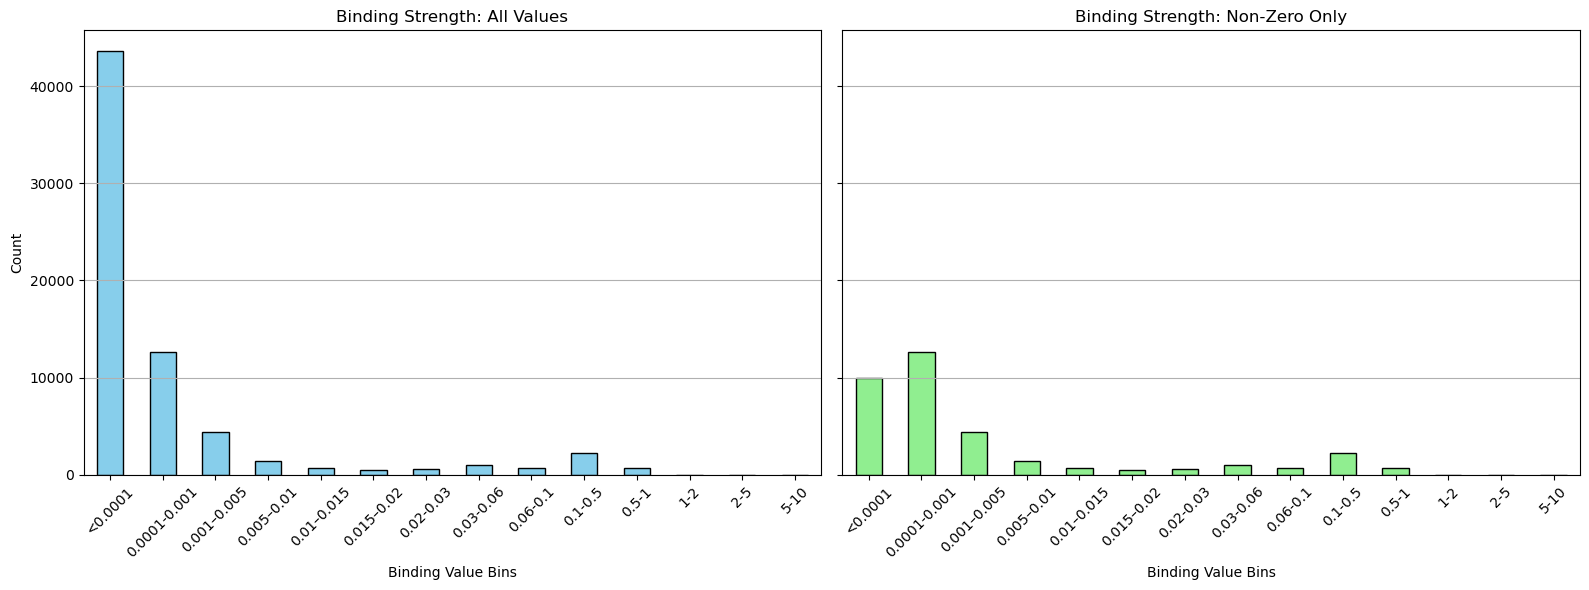

In [6]:
bins = [0.0, 0.0001, 0.001, 0.005, 0.01, 0.015, 0.02, 0.03, 0.06, 0.1, 0.5, 1, 2, 5, 10]
labels = ['<0.0001', '0.0001-0.001', '0.001–0.005', '0.005–0.01', '0.01–0.015', '0.015–0.02',
          '0.02-0.03', '0.03-0.06', '0.06-0.1', '0.1-0.5', '0.5-1', '1-2', '2-5', '5-10']

# Add bin labels to the original data
fractions_df['f_bin'] = pd.cut(fractions_df['f'], bins=bins, labels=labels, right=False)

# Count all values
bin_counts_all = fractions_df['f_bin'].value_counts().sort_index()

# Filter out zeros and count non-zero bins only
non_zero_df = fractions_df[fractions_df['f'] > 0]
non_zero_df['f_bin'] = pd.cut(non_zero_df['f'], bins=bins, labels=labels, right=False)
bin_counts_nonzero = non_zero_df['f_bin'].value_counts().sort_index()

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# All values plot
bin_counts_all.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Binding Strength: All Values')
axes[0].set_xlabel('Binding Value Bins')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')
axes[0].tick_params(axis='x', rotation=45)
#axes[0].set_ylim(0, 50_000)

# Non-zero values plot
bin_counts_nonzero.plot(kind='bar', color='lightgreen', edgecolor='black', ax=axes[1])
axes[1].set_title('Binding Strength: Non-Zero Only')
axes[1].set_xlabel('Binding Value Bins')
axes[1].grid(axis='y')
axes[1].tick_params(axis='x', rotation=45)
#axes[1].set_ylim(0, 15_000)

plt.tight_layout()
plt.show()

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

device = torch.device("cpu") # "cuda")
glycan_encoder = MPNNGlycanEncoder().to(device) #GNNGlycanEncoder().to(device)
protein_encoder = AdvancedGNNProteinEncoder().to(device) #AdvancedGNNProteinEncoder().to(device)

glycan_type = 'SMILES'

random_state = 42

split_mode = 'AND'
use_kfolds = False
k_folds = 0
val_split = 0.5#0.35 # 0.35 if using OR, 0.5 if using AND
#device = 'cpu'

full_indicies, glycan_encodings, protein_encodings = prepare_train_val_datasets(fractions_df, glycans_df, proteins_df, glycan_encoder, protein_encoder, glycan_type, random_state, split_mode, use_kfolds, k_folds, val_split, device)

-------------Test size (% of glycans and proteins as combinations in test set): 50.0% -------------
train size: 29582, test size: 8054, total: 68492
train size: 43.19%, test size: 11.76%
test size % in terms of test/(training+test) size: 21.4%
Total % of dataset used: 54.95%



/opt/miniconda3/envs/test_env/lib/python3.12/site-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


In [8]:
# change binds value of which values we want to consider as non binding
non_binding_threshold = 0#0.0005

train_idx, val_idx = full_indicies[0]
fractions_df['binds'] = (fractions_df['f'] > non_binding_threshold).astype(int)
train_data = fractions_df.loc[train_idx]
val_data = fractions_df.loc[val_idx]

In [9]:
train_data.shape

(29582, 8)

In [10]:
len(train_data[train_data['f'] > non_binding_threshold])

15584

In [11]:
val_data.shape

(8054, 8)

In [12]:
len(val_data[val_data['f'] > non_binding_threshold])

3738

In [13]:
train_data.head(5)

,Unnamed: 0,ObjId,ProteinGroup,Concentration,GlycanID,f,f_bin,binds
6945,30551,1004624,9,0.1,CFG-008-Sp8,0.000255,0.0001-0.001,1
6946,30552,1004624,9,0.1,CFG-009-Sp8,0.000254,0.0001-0.001,1
6947,30553,1004624,9,0.1,CFG-010-Sp15,0.000000,<0.0001,0
6952,30559,1004624,9,0.1,CFG-013-Sp8,0.000000,<0.0001,0
6954,30562,1004624,9,0.1,CFG-016-Sp8,0.000000,<0.0001,0


In [14]:
# Helper function to create feature matrix by combining encodings
def get_features(data_df, glycans_df, proteins_df, glycan_encodings, protein_encodings):
    # Map glycan and protein indices
    glycan_index_map = {name: i for i, name in enumerate(glycans_df['Name'])}
    protein_index_map = {pg: i for i, pg in enumerate(proteins_df['ProteinGroup'])}

    glycan_idx = data_df['GlycanID'].map(glycan_index_map).values
    protein_idx = data_df['ProteinGroup'].map(protein_index_map).values

    # Get encoded vectors from PyTorch tensors
    glycan_feats = glycan_encodings[glycan_idx]
    protein_feats = protein_encodings[protein_idx]

    # Concatenate along feature dimension
    full_feats = torch.cat([glycan_feats, protein_feats], dim=1)

    return full_feats.numpy()

In [15]:

X_train = get_features(train_data, glycans_df, proteins_df, glycan_encodings, protein_encodings)
X_val = get_features(val_data, glycans_df, proteins_df, glycan_encodings, protein_encodings)

y_train = train_data['binds'].values
y_val = val_data['binds'].values

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_val)

log_acc = accuracy_score(y_val, y_pred_log)
print("Logistic Regression Accuracy:", round(log_acc, 4))
print("Logistic Regression:\n", classification_report(y_val, y_pred_log))

Logistic Regression Accuracy: 0.5519
Logistic Regression:
               precision    recall  f1-score   support

           0       0.60      0.51      0.55      4316
           1       0.51      0.60      0.55      3738

    accuracy                           0.55      8054
   macro avg       0.56      0.56      0.55      8054
weighted avg       0.56      0.55      0.55      8054



In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)

rf_acc = accuracy_score(y_val, y_pred_rf)
print("Random Forest Accuracy:", round(rf_acc, 4))
print("Random Forest:\n", classification_report(y_val, y_pred_rf))

Random Forest Accuracy: 0.5453
Random Forest:
               precision    recall  f1-score   support

           0       0.59      0.50      0.54      4316
           1       0.51      0.60      0.55      3738

    accuracy                           0.55      8054
   macro avg       0.55      0.55      0.55      8054
weighted avg       0.55      0.55      0.54      8054



In [18]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_val)

xgb_acc = accuracy_score(y_val, y_pred_xgb)
print("XGBoost Accuracy:", round(xgb_acc, 4))
print("XGBoost:\n", classification_report(y_val, y_pred_xgb))

/opt/miniconda3/envs/test_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:09:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744352353999/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.5248
XGBoost:
               precision    recall  f1-score   support

           0       0.59      0.38      0.46      4316
           1       0.49      0.70      0.58      3738

    accuracy                           0.52      8054
   macro avg       0.54      0.54      0.52      8054
weighted avg       0.54      0.52      0.51      8054



In [19]:
class GlycoProteinDataset(Dataset):
    def __init__(self, fractions_df, glycan_encodings, protein_encodings, glycan_mapping, protein_mapping):
        """
        Args:
            fractions_df: DataFrame with fraction data
            glycan_encodings: Tensor of shape [n_glycans, embedding_dim]
            protein_encodings: Tensor of shape [n_proteins, embedding_dim]
            glycan_mapping: Dict mapping glycan IDs to indices in glycan_encodings
            protein_mapping: Dict mapping protein IDs to indices in protein_encodings
        """
        self.fractions_df = fractions_df
        self.glycan_encodings = glycan_encodings
        self.protein_encodings = protein_encodings
        self.glycan_mapping = glycan_mapping
        self.protein_mapping = protein_mapping
    
    
    def __len__(self):
        return len(self.fractions_df)
    
    
    def __getitem__(self, idx):
        row = self.fractions_df.iloc[idx]
        
        # Get the corresponding encodings using the mappings
        glycan_idx = self.glycan_mapping[row['GlycanID']]
        protein_idx = self.protein_mapping[row['ProteinGroup']]
        
        return {
            'glycan_encoding': self.glycan_encodings[glycan_idx],
            'protein_encoding': self.protein_encodings[protein_idx],
            'concentration': torch.tensor([row['Concentration']], dtype=torch.float32),
            'binds': torch.tensor([row['binds']], dtype=torch.float32),
            'target': torch.tensor([row['f']], dtype=torch.float32)
        }

In [20]:
def calculate_metrics(predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
    """
    Calculate training/validation metrics
    
    Args:
        predictions (torch.Tensor): Model predictions
        targets (torch.Tensor): True values
        
    Returns:
        Dict[str, float]: Dictionary of metric names and values
    """
    # convert values to numpy arrays
    preds_np = predictions.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()
    
    mse = np.mean((preds_np - targets_np) ** 2)
    pearson_corr, _ = pearsonr(preds_np.flatten(), targets_np.flatten())
    
    return {
        'mse': float(mse),
        'pearson': float(pearson_corr)
    }

In [21]:
class DNN_Binary_BindingPredictor(nn.Module):
    def __init__(self, glycan_dim: int, protein_dim: int, hidden_dims: List[int] = [385, 256, 128]):
        """
        Simple DNN for binding prediction
        
        Args:
            glycan_dim (int): Dimension of glycan embeddings
            protein_dim (int): Dimension of protein embeddings
            hidden_dims (List[int]): List of hidden layer dimensions
        """
        super(DNN_Binary_BindingPredictor, self).__init__()
        #super().__init__()#glycan_dim, protein_dim)
                
        input_dim = glycan_dim + protein_dim + 1 # total input feature size
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(input_dim if i==0 else hidden_dims[i-1], hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ) for i, hidden_dim in enumerate(hidden_dims)],
            nn.Linear(hidden_dims[-1], 1),
            nn.Sigmoid()
        )
    
    def forward(self, 
                glycan_encoding: torch.Tensor,
                protein_encoding: torch.Tensor,
                concentration: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        
        Args:
            glycan_encoding (torch.Tensor): Encoded glycan representation
            protein_encoding (torch.Tensor): Encoded protein representation
            concentration (torch.Tensor): Concentration values
            
        Returns:
            torch.Tensor: Predicted fraction bound (values between 0 and 1)
        """
        # combine input features
        x = torch.cat([
            glycan_encoding,
            protein_encoding,
            concentration
        ], dim=-1)
        
        return self.network(x)

In [22]:
class DNNBindingPredictor(nn.Module):
    def __init__(self, glycan_dim: int, protein_dim: int, hidden_dims: List[int] = [512, 256, 128]):
        """
        Simple DNN for binding prediction
        
        Args:
            glycan_dim (int): Dimension of glycan embeddings
            protein_dim (int): Dimension of protein embeddings
            hidden_dims (List[int]): List of hidden layer dimensions
        """
        super(DNNBindingPredictor, self).__init__()#glycan_dim, protein_dim)
                
        input_dim = glycan_dim + protein_dim + 1 # total input feature size
        
        self.network = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(input_dim if i==0 else hidden_dims[i-1], hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.2)
            ) for i, hidden_dim in enumerate(hidden_dims)],
            nn.Linear(hidden_dims[-1], 1),
            nn.Sigmoid()
        )
    
    def forward(self, 
                glycan_encoding: torch.Tensor,
                protein_encoding: torch.Tensor,
                concentration: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        
        Args:
            glycan_encoding (torch.Tensor): Encoded glycan representation
            protein_encoding (torch.Tensor): Encoded protein representation
            concentration (torch.Tensor): Concentration values
            
        Returns:
            torch.Tensor: Predicted fraction bound (values between 0 and 1)
        """
        # combine input features
        x = torch.cat([
            glycan_encoding,
            protein_encoding,
            concentration
        ], dim=-1)
        
        return self.network(x)

In [23]:
# re add here just for resets and testing other params
glycan_encoder = MPNNGlycanEncoder().to(device) #GNNGlycanEncoder().to(device)
protein_encoder = AdvancedGNNProteinEncoder().to(device) #AdvancedGNNProteinEncoder().to(device)

glycan_mapping = {name: idx for idx, name in enumerate(glycans_df['Name'])}
protein_mapping = {name: idx for idx, name in enumerate(proteins_df['ProteinGroup'])}

train_idx, val_idx = full_indicies[0]

train_data = fractions_df.loc[train_idx]
val_data = fractions_df.loc[val_idx]

train_pytorch_dataset = GlycoProteinDataset(
    train_data, glycan_encodings, protein_encodings, glycan_mapping, protein_mapping
)
val_pytorch_dataset = GlycoProteinDataset(
    val_data, glycan_encodings, protein_encodings, glycan_mapping, protein_mapping
)

batch_size = 32

train_loader = DataLoader(
    train_pytorch_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_pytorch_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [24]:
input_dim = glycan_encoder.embedding_dim + protein_encoder.embedding_dim + 1  # Input dimension (glycan + protein + concentration)
print('input dim:', input_dim)


binding_predictor = DNN_Binary_BindingPredictor(glycan_dim=glycan_encoder.embedding_dim, protein_dim=protein_encoder.embedding_dim, hidden_dims=[256, 128, 64, 32]).to(device)


learning_rate = 0.001

optimizer = optim.Adam(
    list(glycan_encoder.parameters()) +
    list(protein_encoder.parameters()) +
    list(binding_predictor.parameters()),
    lr=learning_rate
)


criterion = nn.BCELoss() #nn.MSELoss()



input dim: 385


In [25]:
def _train_epoch(train_type, zero_pred_threshold, train_loader, binding_predictor, glycan_encoder, protein_encoder, optimizer, criterion, device) -> Dict[str, float]:
        glycan_encoder.train()
        protein_encoder.train()
        binding_predictor.train()
        
        total_loss = 0
        all_predictions = []
        all_targets = []
        
        pbar = tqdm(train_loader, desc='Training')
        for batch in pbar:
            
            #print(batch)
            
            glycan_encoding = batch['glycan_encoding'].to(device)
            protein_encoding = batch['protein_encoding'].to(device)
            concentration = batch['concentration'].to(device)
            
            if train_type == 'binary':
                targets = batch['binds'].to(device)
            else:
                targets = batch['target'].to(device)
            
            predictions = binding_predictor(
                glycan_encoding,
                protein_encoding,
                concentration
            )

            # Prevent double-log when using both log_predict=True and a log-based loss
            #apply_log = self.config.log_predict and self.config.loss_type not in ['rmsle', 'log_mae', 'log_l1']
            #if apply_log:
            targets = torch.log(targets + 1)
            predictions = torch.log(predictions + 1)
            
            
            loss = criterion(predictions, targets)
            
            # reset gradients to zero
            optimizer.zero_grad()
            # perform backpropagation to calculate the gradients we need to improve model
            loss.backward(retain_graph=True)
            # update the weights with our loss gradients
            optimizer.step()
            
            # revert predictions and targets to original values for original analysis if using log transform
            #if apply_log:
            predictions = torch.exp(predictions) - 1
            targets = torch.exp(targets) - 1
            
            # track totals
            total_loss += loss.item()
            all_predictions.append(predictions.detach())
            all_targets.append(targets.detach())
            
            # Update progress bar with current loss
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # save metrics
        epoch_predictions = torch.cat(all_predictions)
        epoch_targets = torch.cat(all_targets)
        
        if train_type == 'binary':
            epoch_predictions_binary = (epoch_predictions >= zero_pred_threshold).int()
            epoch_targets_binary = epoch_targets.int()
            
            acc = (epoch_predictions_binary == epoch_targets_binary).float().mean()

            print('metrics == accuracy')
            metrics = float(acc)
        else:
            metrics = calculate_metrics(epoch_predictions, epoch_targets)
        
        print('Train')
        print('total loss:', total_loss)
        print('Metrics:', metrics)

In [26]:
def _validate(train_type, zero_pred_threshold,
              val_loader, binding_predictor, glycan_encoder, protein_encoder, criterion, device) -> Dict[str, float]:
        glycan_encoder.eval()
        protein_encoder.eval()
        binding_predictor.eval()
        
        total_loss = 0
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc='Validating')
            for batch in pbar:
                
                
                glycan_encoding = batch['glycan_encoding'].to(device)
                protein_encoding = batch['protein_encoding'].to(device)
                concentration = batch['concentration'].to(device)
                
                if train_type == 'binary':
                    targets = batch['binds'].to(device)
                else:
                    targets = batch['target'].to(device)
                
                
                predictions = binding_predictor(
                    glycan_encoding,
                    protein_encoding,
                    concentration
                )

                # Prevent double-log when using both log_predict=True and a log-based loss
                #apply_log = self.config.log_predict and self.config.loss_type not in ['rmsle', 'log_mae', 'log_l1']
                #if apply_log:
                targets = torch.log(targets + 1)
                predictions = torch.log(predictions + 1)
                
                loss = criterion(predictions, targets)
                
                # revert predictions and targets to original values for original analysis if using log transform
                #$if apply_log:
                predictions = torch.exp(predictions) - 1
                targets = torch.exp(targets) - 1
                
                # track totals
                total_loss += loss.item()
                all_predictions.append(predictions)
                all_targets.append(targets)
                
                # Update progress bar with current loss
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # save metrics
        val_predictions = torch.cat(all_predictions)
        val_targets = torch.cat(all_targets)
        
        if train_type == 'binary':
            epoch_predictions_binary = (val_predictions >= zero_pred_threshold).int()
            epoch_targets_binary = val_targets.int()
            
            acc = (epoch_predictions_binary == epoch_targets_binary).float().mean()

            print('metrics == accuracy')
            metrics = float(acc)
        else:
            metrics = calculate_metrics(val_predictions, val_targets)
        
        print('Validation')
        print('total loss:', total_loss)
        print('Metrics:', metrics)

In [27]:
epochs = 5
zero_pred_threshold = 0.5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_metrics = _train_epoch('binary', zero_pred_threshold, train_loader, binding_predictor, glycan_encoder, protein_encoder, optimizer, criterion, device)
    val_metrics = _validate('binary', zero_pred_threshold, val_loader, binding_predictor, glycan_encoder, protein_encoder, criterion, device)
    

Epoch 1/5


Training: 100%|██████████| 925/925 [00:05<00:00, 163.26it/s, loss=0.7681]


metrics == accuracy
Train
total loss: 600.3490109443665
Metrics: 0.5631126761436462


Validating: 100%|██████████| 252/252 [00:00<00:00, 343.68it/s, loss=0.6771]


metrics == accuracy
Validation
total loss: 156.0499805212021
Metrics: 0.6001986861228943
Epoch 2/5


Training: 100%|██████████| 925/925 [00:04<00:00, 186.39it/s, loss=0.6761]


metrics == accuracy
Train
total loss: 595.1162474155426
Metrics: 0.5737272500991821


Validating: 100%|██████████| 252/252 [00:00<00:00, 366.28it/s, loss=0.5712]


metrics == accuracy
Validation
total loss: 156.15266609191895
Metrics: 0.6044201850891113
Epoch 3/5


Training: 100%|██████████| 925/925 [00:05<00:00, 184.55it/s, loss=0.7272]


metrics == accuracy
Train
total loss: 593.6047070026398
Metrics: 0.580048680305481


Validating: 100%|██████████| 252/252 [00:00<00:00, 369.72it/s, loss=0.5925]


metrics == accuracy
Validation
total loss: 156.8146932721138
Metrics: 0.5938664078712463
Epoch 4/5


Training: 100%|██████████| 925/925 [00:05<00:00, 183.65it/s, loss=0.5781]


metrics == accuracy
Train
total loss: 592.9198585152626
Metrics: 0.5805557370185852


Validating: 100%|██████████| 252/252 [00:00<00:00, 359.50it/s, loss=0.6841]


metrics == accuracy
Validation
total loss: 157.15638652443886
Metrics: 0.5681648850440979
Epoch 5/5


Training: 100%|██████████| 925/925 [00:05<00:00, 181.83it/s, loss=0.7389]


metrics == accuracy
Train
total loss: 592.2744877934456
Metrics: 0.5863363146781921


Validating: 100%|██████████| 252/252 [00:00<00:00, 361.12it/s, loss=0.6513]


metrics == accuracy
Validation
total loss: 157.04960376024246
Metrics: 0.5537620782852173


In [28]:
#torch.save(glycan_encoder.state_dict(), "./binary_binding_classif/glycan_encoder_weights.pth")
#torch.save(protein_encoder.state_dict(), "./binary_binding_classif/protein_encoder_weights.pth")

In [29]:
#glycan_encoder.load_state_dict(torch.load("./binary_binding_classif/glycan_encoder_weights.pth", map_location=device))
#protein_encoder.load_state_dict(torch.load("./binary_binding_classif/protein_encoder_weights.pth", map_location=device))

In [30]:
glycan_encodings = glycan_encoder.encode_batch(glycans_df[glycan_type].tolist(), device)
protein_encodings = protein_encoder.encode_batch(proteins_df['Amino Acid Sequence'].tolist(), device)
X_train = get_features(train_data, glycans_df, proteins_df, glycan_encodings, protein_encodings)
X_val = get_features(val_data, glycans_df, proteins_df, glycan_encodings, protein_encodings)

y_train = train_data['binds'].values
y_val = val_data['binds'].values

In [31]:

#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import classification_report, accuracy_score

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_val)

log_acc = accuracy_score(y_val, y_pred_log)
print("Logistic Regression Accuracy:", round(log_acc, 4))
print("Logistic Regression:\n", classification_report(y_val, y_pred_log))

Logistic Regression Accuracy: 0.5942
Logistic Regression:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64      4316
           1       0.57      0.50      0.53      3738

    accuracy                           0.59      8054
   macro avg       0.59      0.59      0.59      8054
weighted avg       0.59      0.59      0.59      8054



In [32]:
train_data.head(3)

,Unnamed: 0,ObjId,ProteinGroup,Concentration,GlycanID,f,f_bin,binds
6945,30551,1004624,9,0.1,CFG-008-Sp8,0.000255,0.0001-0.001,1
6946,30552,1004624,9,0.1,CFG-009-Sp8,0.000254,0.0001-0.001,1
6947,30553,1004624,9,0.1,CFG-010-Sp15,0.000000,<0.0001,0


In [33]:
X_val = get_features(val_data, glycans_df, proteins_df, glycan_encodings, protein_encodings)

val_preds = log_clf.predict(X_val)

In [34]:
from sklearn.metrics import mean_squared_error

# Step 2: Get indices where model predicted "no binding" (0)
zero_pred_mask = val_preds == 0

# Step 3: Get true binding values (target 'f') for those rows
true_f_values = val_data.loc[zero_pred_mask, 'f'].values

# Step 4: Create predicted array of all zeros
predicted_zeros = np.zeros_like(true_f_values)

# Step 5: Calculate MSE
mse_no_binding_preds = mean_squared_error(true_f_values, predicted_zeros)

print(f"MSE for predicted-zero group: {mse_no_binding_preds:.6f}")

MSE for predicted-zero group: 0.002279


In [35]:
non_zero_train = train_data[train_data['binds'] == 1]

non_zero_val = val_data[val_preds == 1].copy()

In [36]:
# create new data and encoders only for predicting non zero binds
non_zero_train_pytorch_dataset = GlycoProteinDataset(
    non_zero_train, glycan_encodings, protein_encodings, glycan_mapping, protein_mapping
)
non_zero_val_pytorch_dataset = GlycoProteinDataset(
    non_zero_val, glycan_encodings, protein_encodings, glycan_mapping, protein_mapping
)

batch_size = 32

non_zero_train_loader = DataLoader(
    non_zero_train_pytorch_dataset,
    batch_size=batch_size,
    shuffle=True,
)
non_zero_val_loader = DataLoader(
    non_zero_val_pytorch_dataset,
    batch_size=batch_size,
    shuffle=True,
)

non_zero_glycan_encoder = MPNNGlycanEncoder().to(device) #GNNGlycanEncoder().to(device)
non_zero_protein_encoder = AdvancedGNNProteinEncoder().to(device) #AdvancedGNNProteinEncoder().to(device)

In [37]:
input_dim = glycan_encoder.embedding_dim + protein_encoder.embedding_dim + 1  # Input dimension (glycan + protein + concentration)
print('input dim:', input_dim)


non_zero_binding_predictor = DNNBindingPredictor(glycan_dim=non_zero_glycan_encoder.embedding_dim, protein_dim=non_zero_protein_encoder.embedding_dim, hidden_dims=[256, 128, 64]).to(device)


learning_rate = 0.001

optimizer = optim.Adam(
    list(non_zero_glycan_encoder.parameters()) +
    list(non_zero_protein_encoder.parameters()) +
    list(non_zero_binding_predictor.parameters()),
    lr=learning_rate
)


criterion = nn.MSELoss()

input dim: 385


In [38]:
epochs = 7
#doesnt matter here
zero_pred_threshold = 0.5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    train_metrics = _train_epoch('regression', zero_pred_threshold, non_zero_train_loader, non_zero_binding_predictor, non_zero_glycan_encoder, non_zero_protein_encoder, optimizer, criterion, device)
    

    val_metrics = _validate('regression', zero_pred_threshold, non_zero_val_loader, non_zero_binding_predictor, non_zero_glycan_encoder, non_zero_protein_encoder, criterion, device)
    

Epoch 1/7


Training: 100%|██████████| 487/487 [00:02<00:00, 181.43it/s, loss=0.0044]


Train
total loss: 23.80861213989556
Metrics: {'mse': 0.08932340145111084, 'pearson': 0.09256148338317871}


Validating: 100%|██████████| 102/102 [00:00<00:00, 283.56it/s, loss=0.0272]


Validation
total loss: 2.0270349169149995
Metrics: {'mse': 0.03295329213142395, 'pearson': 0.07720168679952621}
Epoch 2/7


Training: 100%|██████████| 487/487 [00:02<00:00, 194.36it/s, loss=0.0162]


Train
total loss: 4.333120379538741
Metrics: {'mse': 0.01341945119202137, 'pearson': 0.045443519949913025}


Validating: 100%|██████████| 102/102 [00:00<00:00, 243.41it/s, loss=0.0085]


Validation
total loss: 0.5604532556608319
Metrics: {'mse': 0.008463953621685505, 'pearson': 0.1132236048579216}
Epoch 3/7


Training: 100%|██████████| 487/487 [00:02<00:00, 197.88it/s, loss=0.0025]


Train
total loss: 3.8832379291998222
Metrics: {'mse': 0.011983455158770084, 'pearson': 0.06450251489877701}


Validating: 100%|██████████| 102/102 [00:00<00:00, 242.90it/s, loss=0.0128]


Validation
total loss: 0.5626282336888835
Metrics: {'mse': 0.008502057753503323, 'pearson': 0.08968639373779297}
Epoch 4/7


Training: 100%|██████████| 487/487 [00:02<00:00, 194.22it/s, loss=0.0053]


Train
total loss: 3.8006074322911445
Metrics: {'mse': 0.011734717525541782, 'pearson': 0.10985208302736282}


Validating: 100%|██████████| 102/102 [00:00<00:00, 249.11it/s, loss=0.0072]


Validation
total loss: 0.562719415378524
Metrics: {'mse': 0.008554317988455296, 'pearson': 0.057929374277591705}
Epoch 5/7


Training: 100%|██████████| 487/487 [00:02<00:00, 198.69it/s, loss=0.0078]


Train
total loss: 3.814421143004438
Metrics: {'mse': 0.011782393790781498, 'pearson': 0.0909886583685875}


Validating: 100%|██████████| 102/102 [00:00<00:00, 246.16it/s, loss=0.0024]


Validation
total loss: 0.5473391629639082
Metrics: {'mse': 0.008354895748198032, 'pearson': 0.15550819039344788}
Epoch 6/7


Training: 100%|██████████| 487/487 [00:02<00:00, 198.10it/s, loss=0.0042]


Train
total loss: 3.787656568107195
Metrics: {'mse': 0.011706119403243065, 'pearson': 0.10807929933071136}


Validating: 100%|██████████| 102/102 [00:00<00:00, 240.81it/s, loss=0.0096]


Validation
total loss: 0.5637488710635807
Metrics: {'mse': 0.008497578091919422, 'pearson': 0.10856620967388153}
Epoch 7/7


Training: 100%|██████████| 487/487 [00:02<00:00, 195.53it/s, loss=0.0009]


Train
total loss: 3.7450768709823024
Metrics: {'mse': 0.011569381691515446, 'pearson': 0.13433405756950378}


Validating: 100%|██████████| 102/102 [00:00<00:00, 242.79it/s, loss=0.0009]

Validation
total loss: 0.5541557292162906
Metrics: {'mse': 0.008404361084103584, 'pearson': 0.13521692156791687}


## Combine all into one

In [39]:
val_preds = log_clf.predict(X_val)  # binary 0/1

non_zero_binding_predictor.eval()
non_zero_glycan_encoder.eval()
non_zero_protein_encoder.eval()

non_zero_predictions = []
non_zero_indices = []

with torch.no_grad():
    for i, batch in enumerate(non_zero_val_loader):
        glycan_encoding = batch['glycan_encoding'].to(device)
        protein_encoding = batch['protein_encoding'].to(device)
        concentration = batch['concentration'].to(device)

        preds = non_zero_binding_predictor(
            glycan_encoding,
            protein_encoding,
            concentration
        )
        non_zero_predictions.append(preds.cpu())
        # Track index from val_data to place back into full prediction array
        non_zero_indices.extend(batch['target'].cpu().numpy().tolist())  # Optionally keep row index


non_zero_predictions = torch.cat(non_zero_predictions).squeeze().numpy()


# Step 3a: Start with all zeros (logistic model predicts 0 ⇒ predict 0.0)
full_predictions = np.zeros(len(val_data))

# Step 3b: Get indices where logistic model predicted 1 (non-zero)
non_zero_indices_mask = val_preds == 1

# Step 3c: Fill those predictions with actual predicted values
full_predictions[non_zero_indices_mask] = non_zero_predictions

In [40]:
true_targets = val_data['f'].values
hybrid_mse = mean_squared_error(true_targets, full_predictions)

print(f"Zero-inflated hybrid model MSE: {hybrid_mse:.6f}")

Zero-inflated hybrid model MSE: 0.004905


In [41]:
metrics = calculate_metrics(torch.from_numpy(full_predictions), torch.from_numpy(true_targets))
metrics

{'mse': 0.004904500173293548, 'pearson': 0.07773509634687722}

Use zero-inflated regression models like ZeroInflatedGamma, ZeroInflatedPoisson (mainly for count data, but some packages support continuous).

could build a two-head model: one head predicts probability of binding, another predicts continuous strength (similar to multitask learning).
